# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [6]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=4)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 8


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


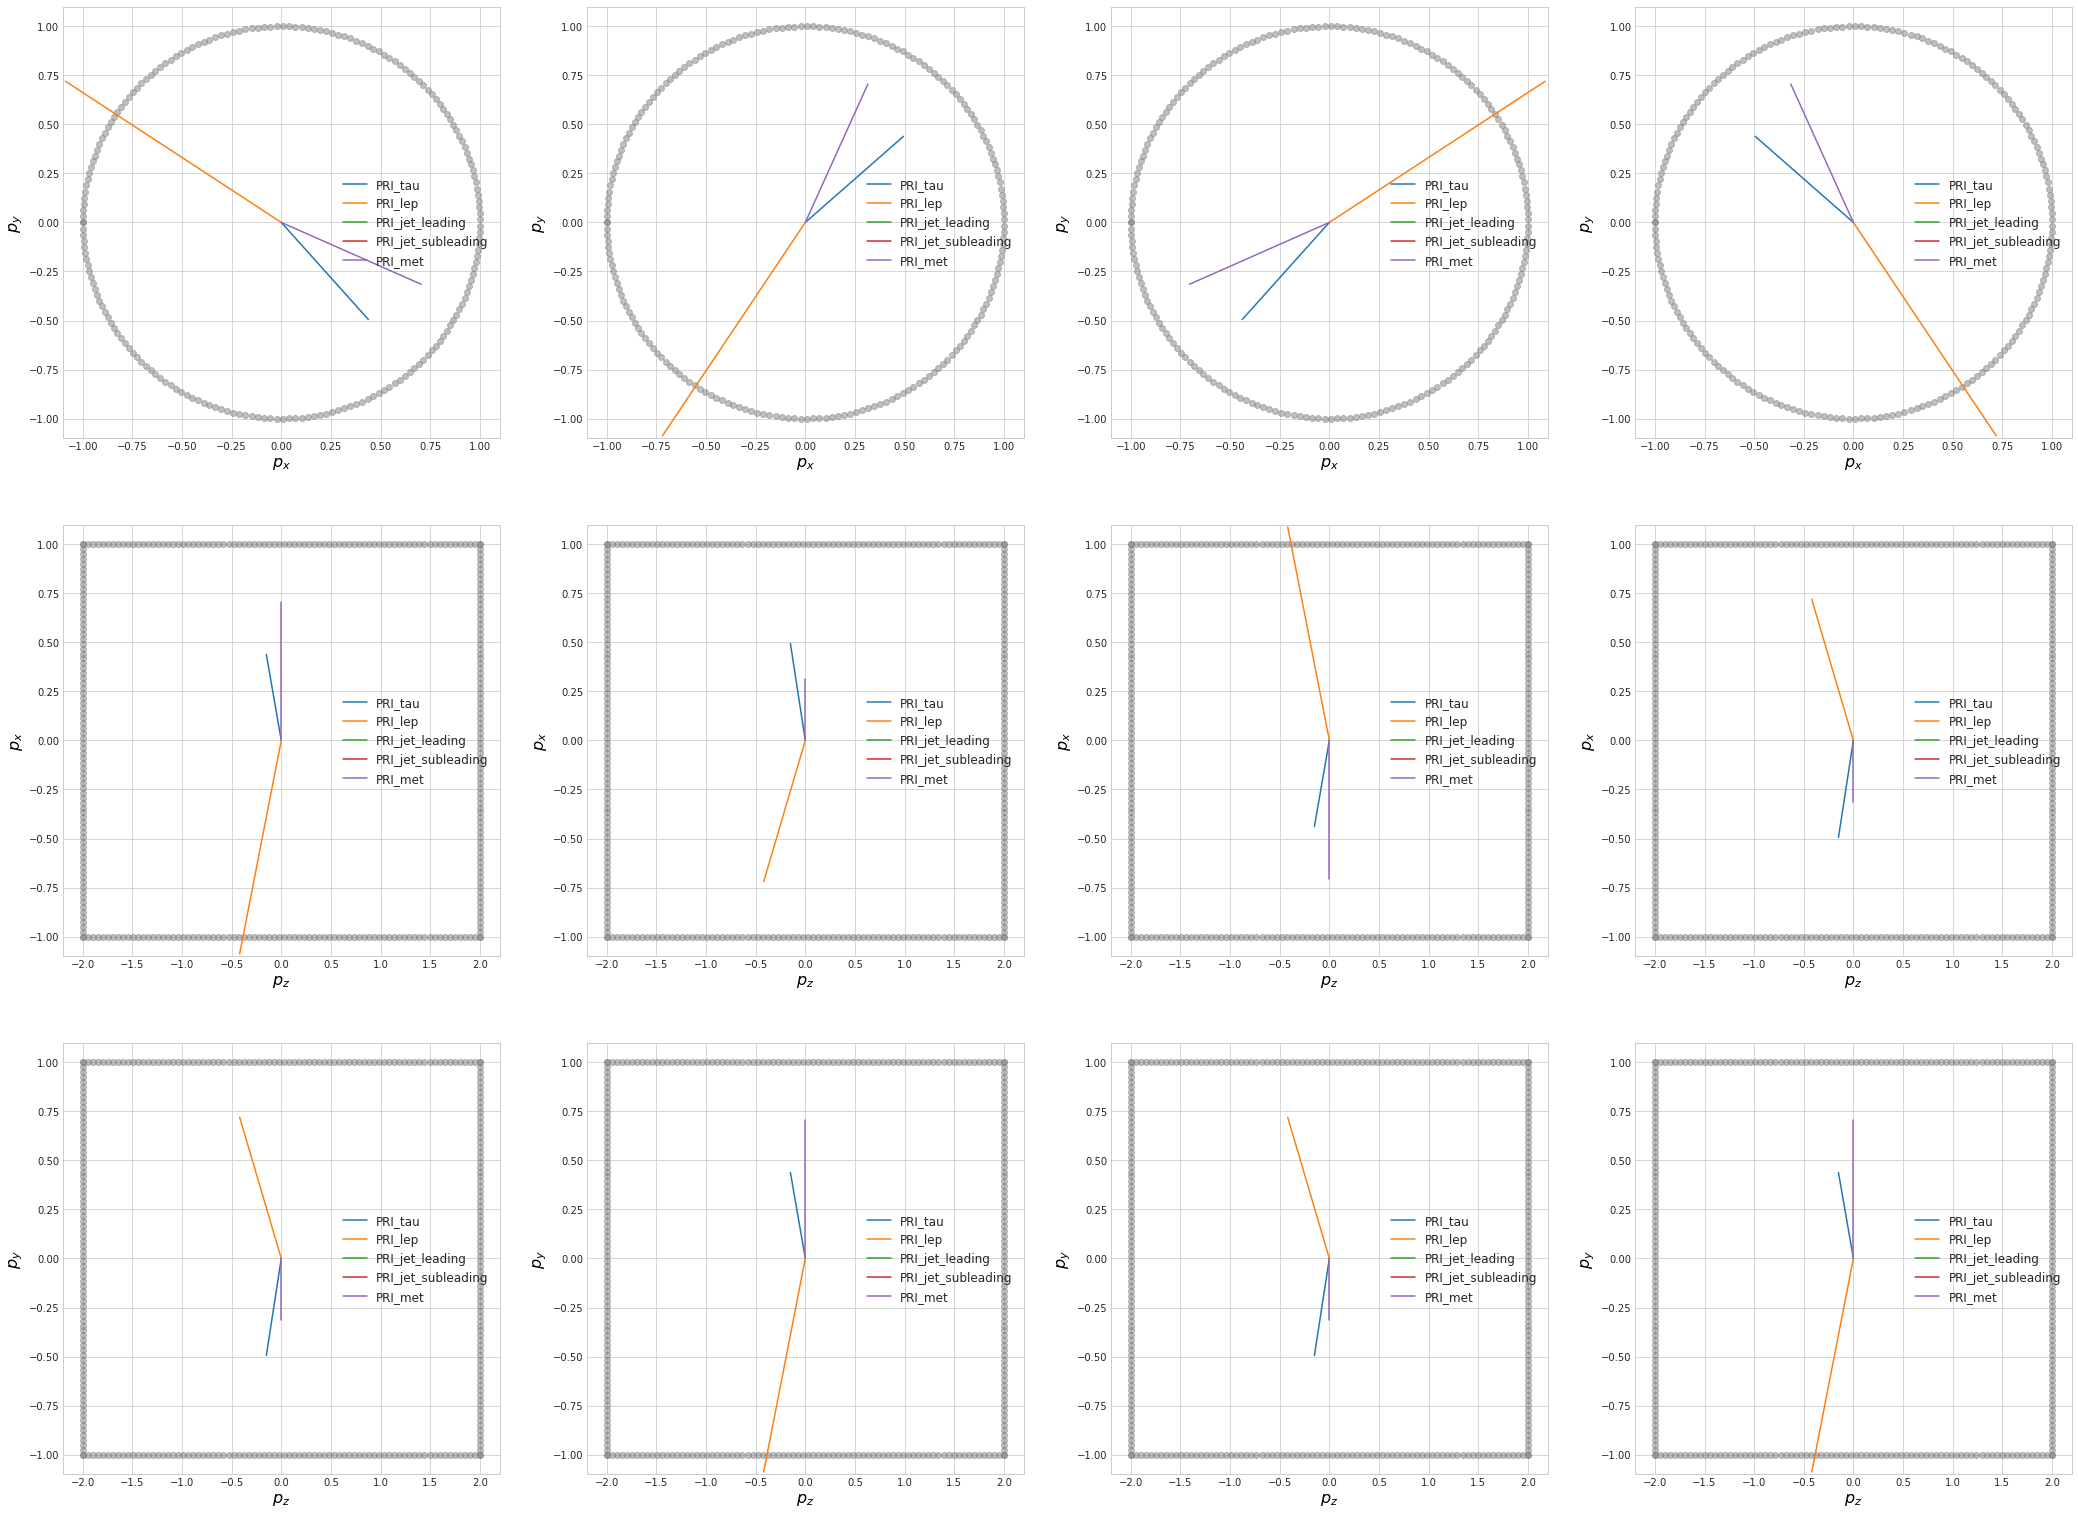

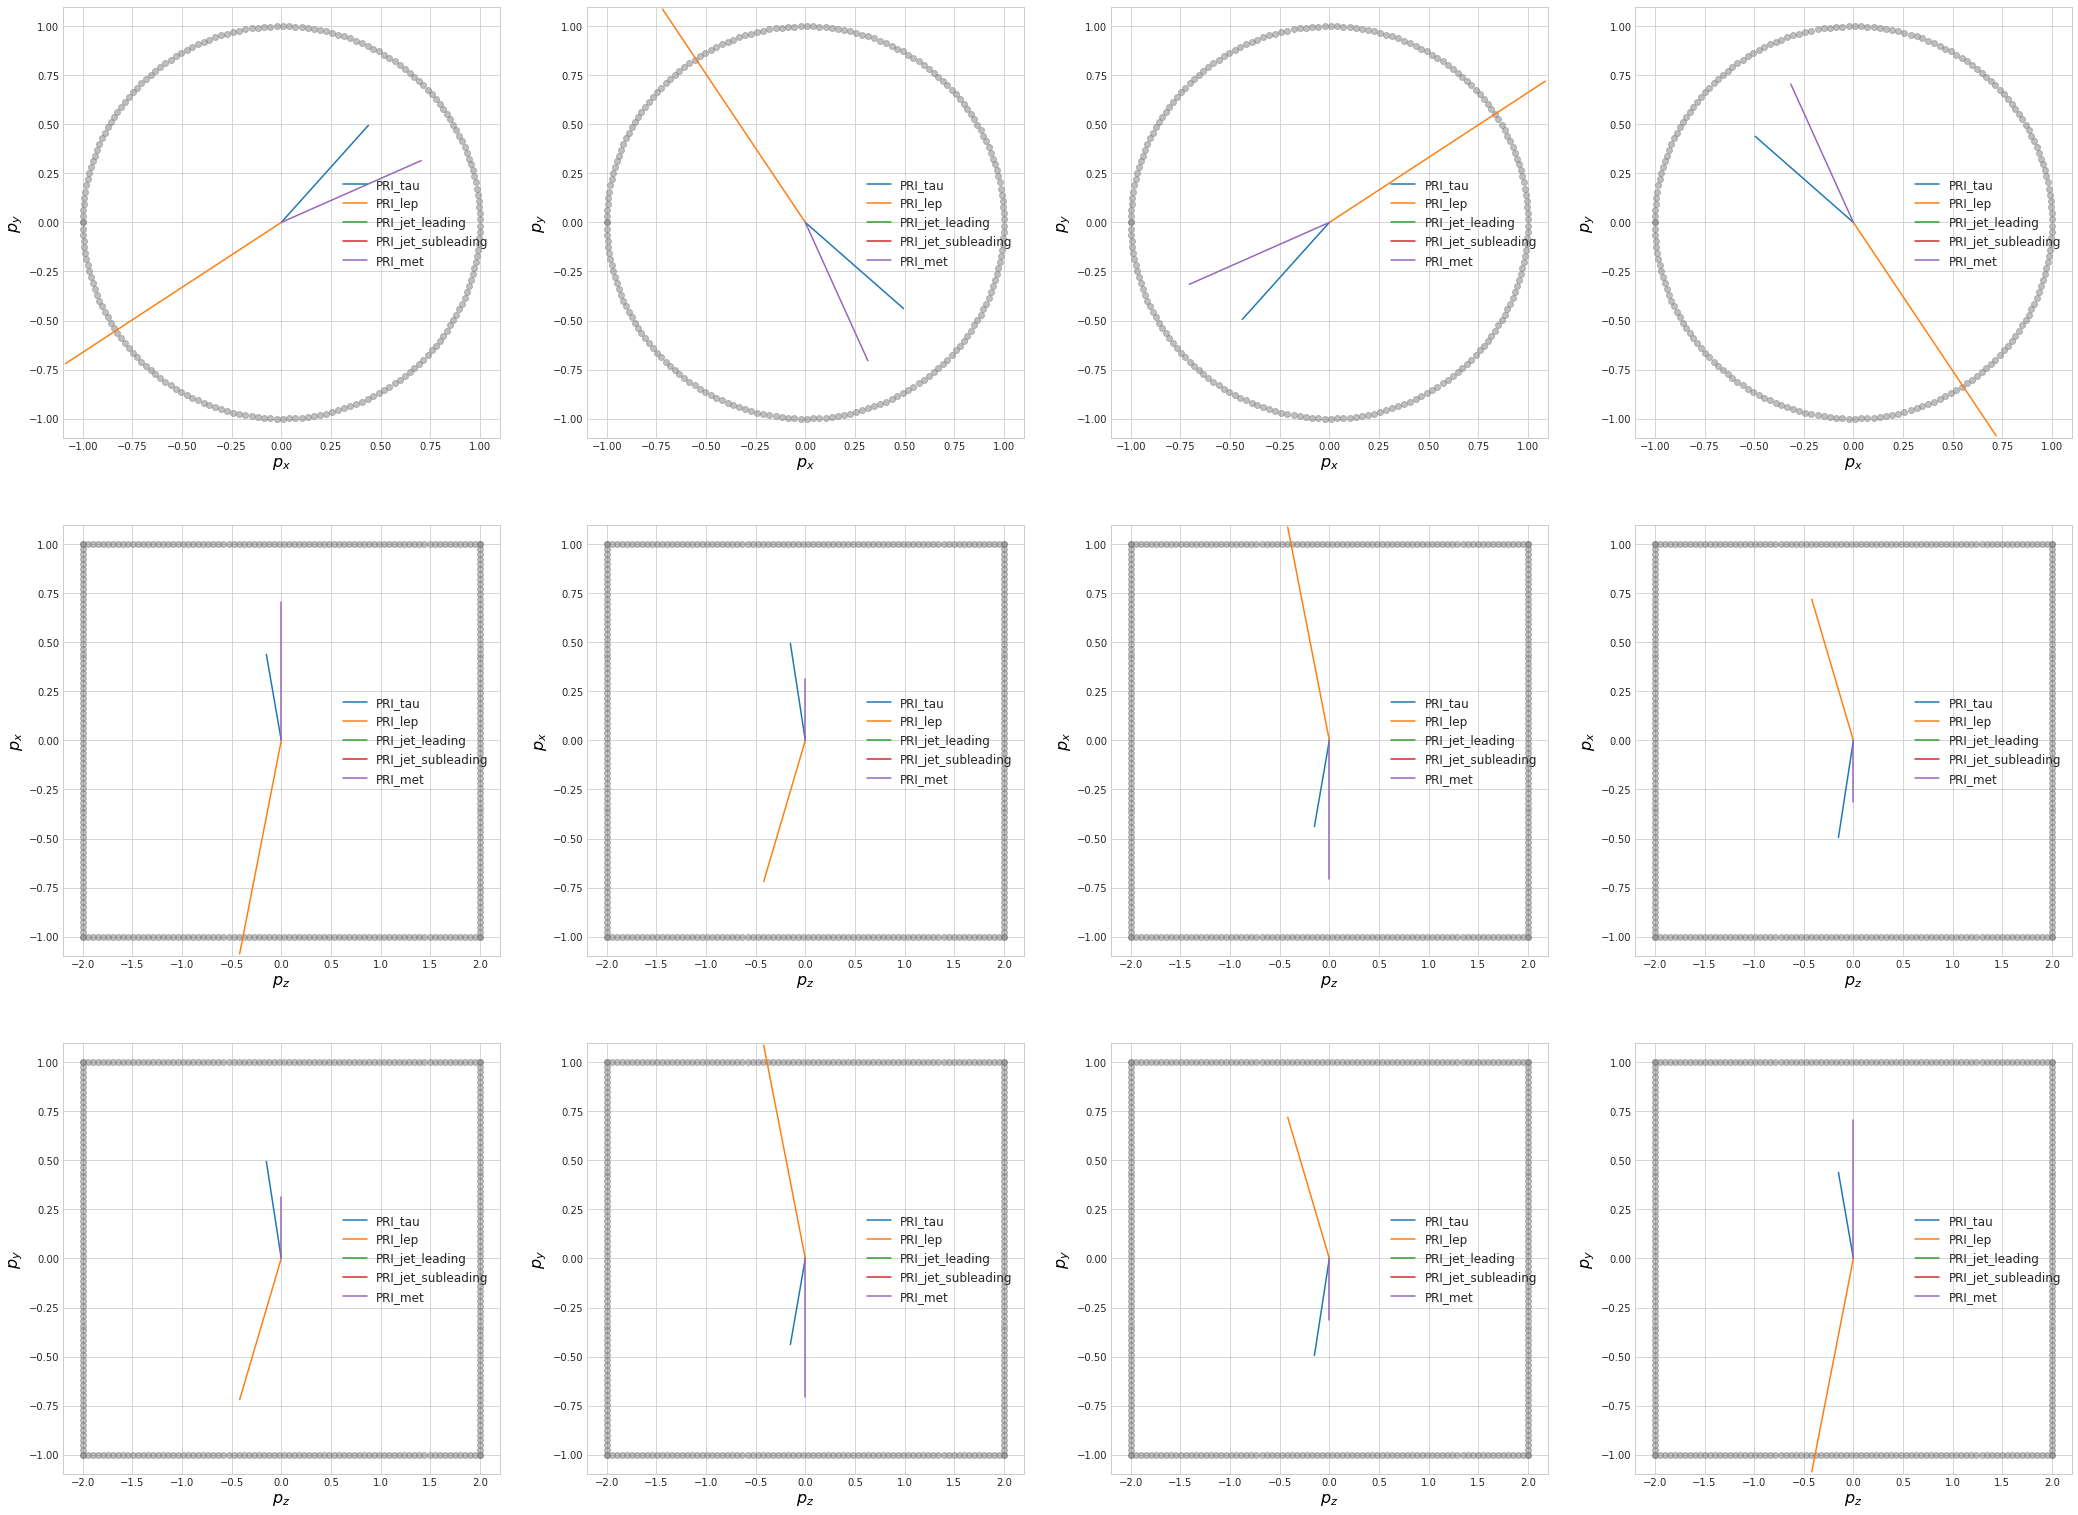

In [7]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.490s 


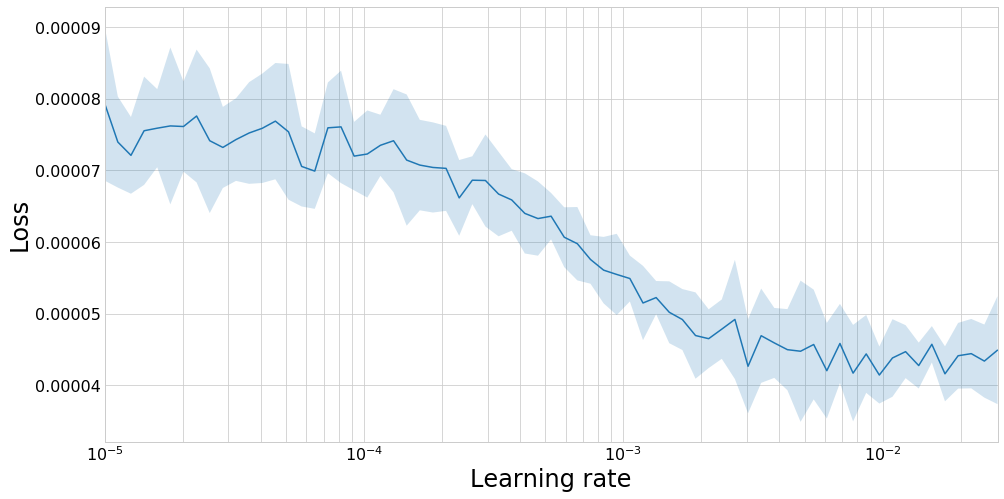

______________________________________



In [8]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [9]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101183). Check your callbacks.
  % delta_t_median)


1 New best found: 3.861416391090566e-05
2 New best found: 3.521695621387371e-05
3 New best found: 3.4552566779987314e-05
5 New best found: 3.4165908526110886e-05
6 New best found: 3.312918998767099e-05
10 New best found: 3.308785628850149e-05
11 New best found: 3.2677363641128594e-05
12 New best found: 3.255215629336118e-05
13 New best found: 3.2299926994196245e-05
14 New best found: 3.21093249060098e-05
15 New best found: 3.209551869031204e-05
24 New best found: 3.1924416881880844e-05
26 New best found: 3.1778453007264296e-05
28 New best found: 3.17276435457188e-05
29 New best found: 3.161640412288482e-05
50 New best found: 3.150654646773581e-05
52 New best found: 3.136764157365423e-05
54 New best found: 3.13143585741787e-05
55 New best found: 3.12348220838852e-05
61 New best found: 3.123444870582083e-05
87 New best found: 3.123380829188606e-05
104 New best found: 3.1205980609273134e-05
105 New best found: 3.117743190191957e-05
107 New best found: 3.117642092684848e-05
109 New best fo

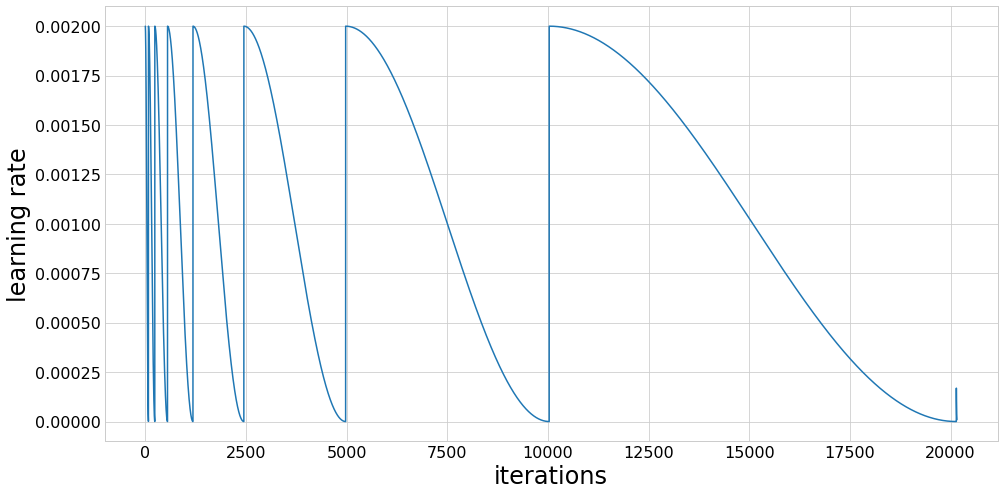

Fold took 232.228s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255432). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128141). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9097945823866413e-05
2 New best found: 3.7069167789240225e-05
3 New best found: 3.612085550554941e-05
5 New best found: 3.50970807018674e-05
6 New best found: 3.472243851129461e-05
7 New best found: 3.458909196357089e-05
10 New best found: 3.4309931543171844e-05
12 New best found: 3.363175870564376e-05
13 New best found: 3.352716345502517e-05
14 New best found: 3.3347306672319915e-05
15 New best found: 3.334304568482203e-05
24 New best found: 3.320070783400688e-05
25 New best found: 3.3017380677303054e-05
26 New best found: 3.299161988103704e-05
27 New best found: 3.294009376961095e-05
28 New best found: 3.2810829715695515e-05
29 New best found: 3.279617631023031e-05
30 New best found: 3.2768488026403715e-05
48 New best found: 3.272815364355271e-05
50 New best found: 3.254082053733518e-05
51 New best found: 3.253517425026076e-05
54 New best found: 3.253460361738769e-05
57 New best found: 3.244843900552088e-05
59 New best found: 3.237538312891029e-05
60 New best foun

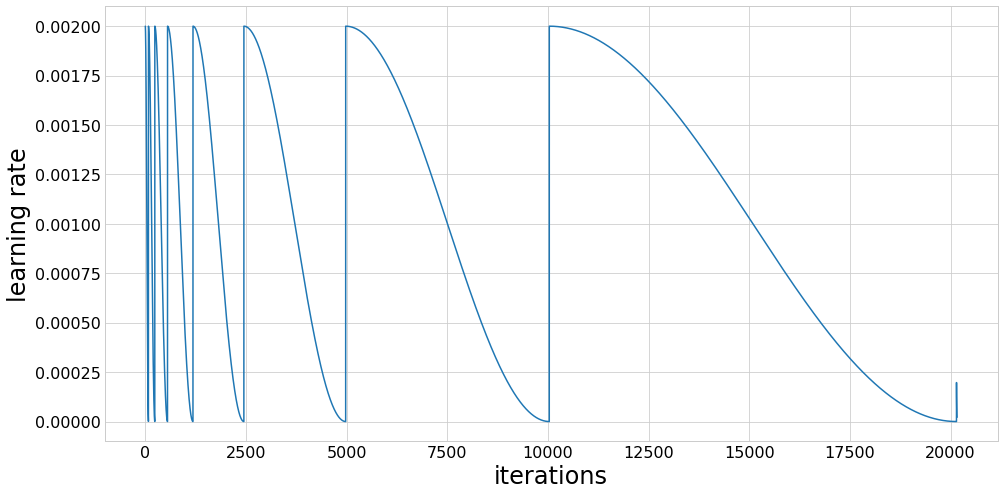

Fold took 233.340s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244754). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122895). Check your callbacks.
  % delta_t_median)


1 New best found: 3.875571733505479e-05
2 New best found: 3.6529399045366793e-05
3 New best found: 3.564212034569931e-05
4 New best found: 3.5326361284796784e-05
5 New best found: 3.435861724470555e-05
6 New best found: 3.410008485233463e-05
7 New best found: 3.388933171537604e-05
9 New best found: 3.3813091013814333e-05
12 New best found: 3.335549617758704e-05
13 New best found: 3.314110805821053e-05
14 New best found: 3.2962129468734345e-05
15 New best found: 3.2918786662899405e-05
24 New best found: 3.2843973253352236e-05
25 New best found: 3.255519398327711e-05
27 New best found: 3.234492353365225e-05
28 New best found: 3.230366262408438e-05
29 New best found: 3.2239446332647085e-05
30 New best found: 3.222090835312846e-05
31 New best found: 3.22098752326541e-05
49 New best found: 3.2164703926444924e-05
50 New best found: 3.2158650969116664e-05
51 New best found: 3.2119123279222526e-05
52 New best found: 3.209293944310444e-05
53 New best found: 3.1947833417249266e-05
54 New best fo

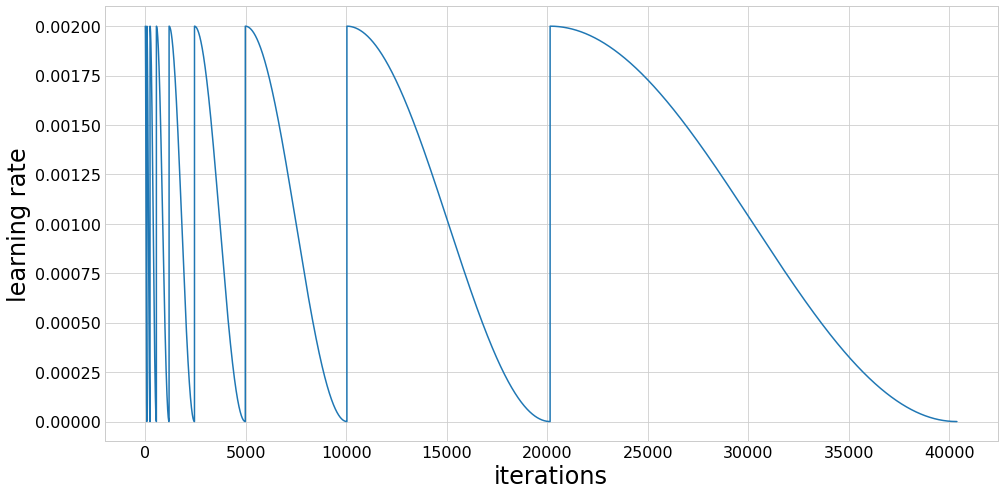

Fold took 475.407s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287422). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144091). Check your callbacks.
  % delta_t_median)


1 New best found: 3.927643568458734e-05
2 New best found: 3.635339435422793e-05
3 New best found: 3.5530758192180656e-05
5 New best found: 3.4554909756116105e-05
6 New best found: 3.428029774659081e-05
7 New best found: 3.407287984155119e-05
10 New best found: 3.4025188707892086e-05
11 New best found: 3.375338066034601e-05
12 New best found: 3.3565431163151516e-05
13 New best found: 3.340537145850249e-05
14 New best found: 3.323304428049596e-05
15 New best found: 3.3194196684053167e-05
23 New best found: 3.3112816650100284e-05
24 New best found: 3.290031611395534e-05
25 New best found: 3.2764130338910034e-05
27 New best found: 3.2622511605586624e-05
28 New best found: 3.258771045002504e-05
30 New best found: 3.257884308404755e-05
31 New best found: 3.257321033088374e-05
48 New best found: 3.257249002417666e-05
49 New best found: 3.2510401894978714e-05
52 New best found: 3.248034430216648e-05
54 New best found: 3.24547947224346e-05
55 New best found: 3.244551706156926e-05
57 New best fo

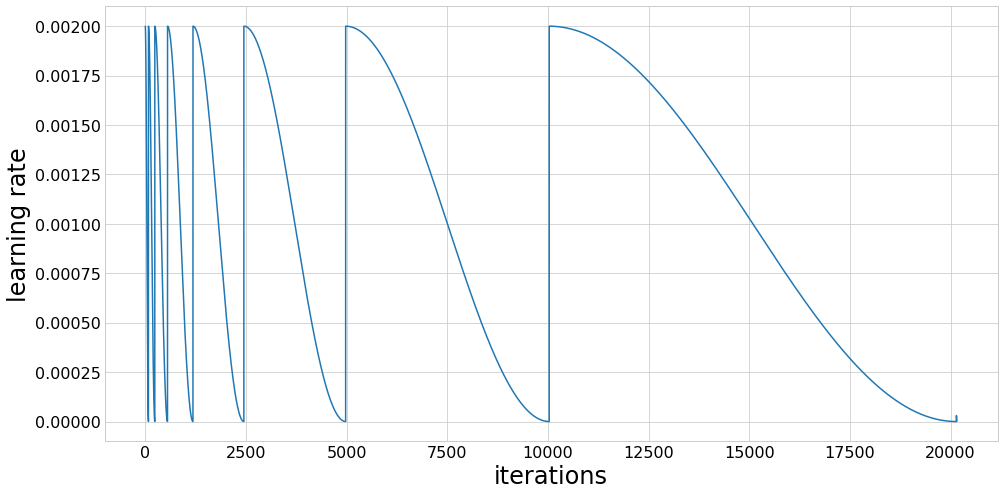

Fold took 246.857s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287514). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144101). Check your callbacks.
  % delta_t_median)


1 New best found: 3.984825898879102e-05
2 New best found: 3.735190586316167e-05
3 New best found: 3.60899223664677e-05
4 New best found: 3.554005133536043e-05
5 New best found: 3.476293932080802e-05
6 New best found: 3.441037951644805e-05
7 New best found: 3.427166846686226e-05
11 New best found: 3.4112970163157676e-05
12 New best found: 3.381255887550872e-05
13 New best found: 3.357583926070581e-05
14 New best found: 3.346365577356805e-05
15 New best found: 3.345160034494015e-05
27 New best found: 3.330495456397355e-05
28 New best found: 3.3299117530028476e-05
29 New best found: 3.324359740772247e-05
30 New best found: 3.321705598897553e-05
31 New best found: 3.321216100317572e-05
46 New best found: 3.309620901739663e-05
49 New best found: 3.286834633222398e-05
50 New best found: 3.279225104312549e-05
55 New best found: 3.2770502276084724e-05
58 New best found: 3.270185132322602e-05
59 New best found: 3.266663279385271e-05
102 New best found: 3.266127848253152e-05
103 New best found: 

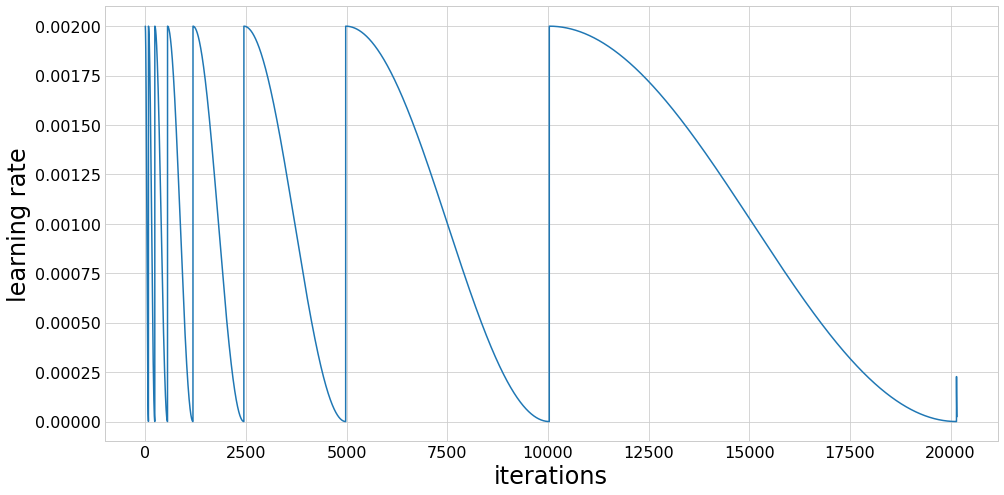

Fold took 244.194s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.338772). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169983). Check your callbacks.
  % delta_t_median)


1 New best found: 3.873130531116892e-05
2 New best found: 3.569466486260053e-05
3 New best found: 3.5224730139708575e-05
5 New best found: 3.450844261981652e-05
6 New best found: 3.3842780794930134e-05
7 New best found: 3.374388100321406e-05
11 New best found: 3.330427602001061e-05
13 New best found: 3.3045291816524896e-05
14 New best found: 3.299288544157312e-05
15 New best found: 3.2973360695746496e-05
23 New best found: 3.289723586802399e-05
24 New best found: 3.2706231992989294e-05
25 New best found: 3.2614362132226376e-05
26 New best found: 3.252290916490001e-05
27 New best found: 3.2439434767424006e-05
48 New best found: 3.243507094295412e-05
49 New best found: 3.2419463593024066e-05
51 New best found: 3.227184018682987e-05
53 New best found: 3.226845049446051e-05
54 New best found: 3.2218159192295504e-05
58 New best found: 3.21209740282284e-05
59 New best found: 3.209057746205137e-05
61 New best found: 3.2069542474239466e-05
62 New best found: 3.206592243954776e-05
106 New best 

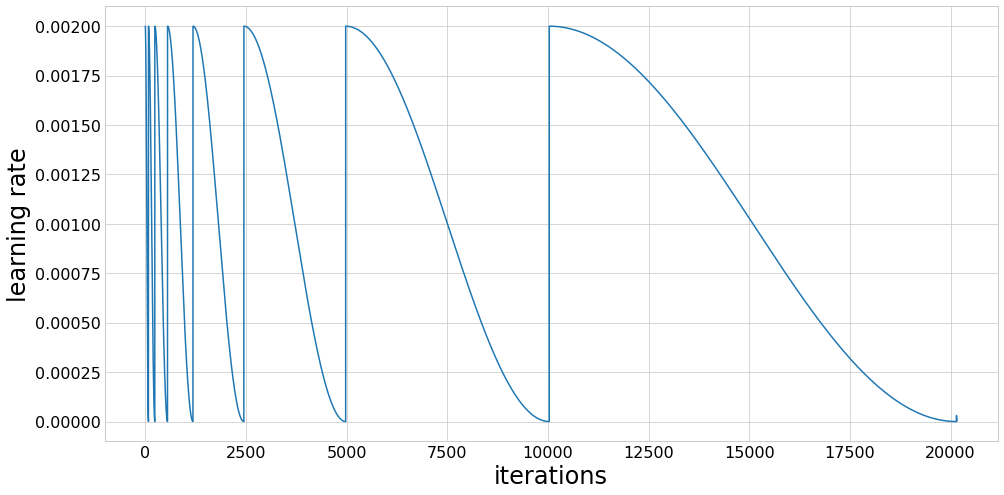

Fold took 249.102s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.351570). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176160). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9209149753151e-05
2 New best found: 3.750055776326917e-05
3 New best found: 3.6085962208744605e-05
4 New best found: 3.569785995205166e-05
5 New best found: 3.51402709420654e-05
6 New best found: 3.4697747918835375e-05
7 New best found: 3.4440677221573425e-05
10 New best found: 3.413881358865183e-05
11 New best found: 3.408307616919046e-05
13 New best found: 3.352749316545669e-05
14 New best found: 3.3388863333675545e-05
15 New best found: 3.338162654399639e-05
21 New best found: 3.331062021752587e-05
23 New best found: 3.317223546619061e-05
24 New best found: 3.303033550037071e-05
25 New best found: 3.301680680015124e-05
26 New best found: 3.298801965429448e-05
27 New best found: 3.287229239504086e-05
28 New best found: 3.279042026551906e-05
29 New best found: 3.272057096764911e-05
30 New best found: 3.271956263342872e-05
31 New best found: 3.271416934730951e-05
42 New best found: 3.267933327588253e-05
48 New best found: 3.2548760925419626e-05
51 New best found: 3.

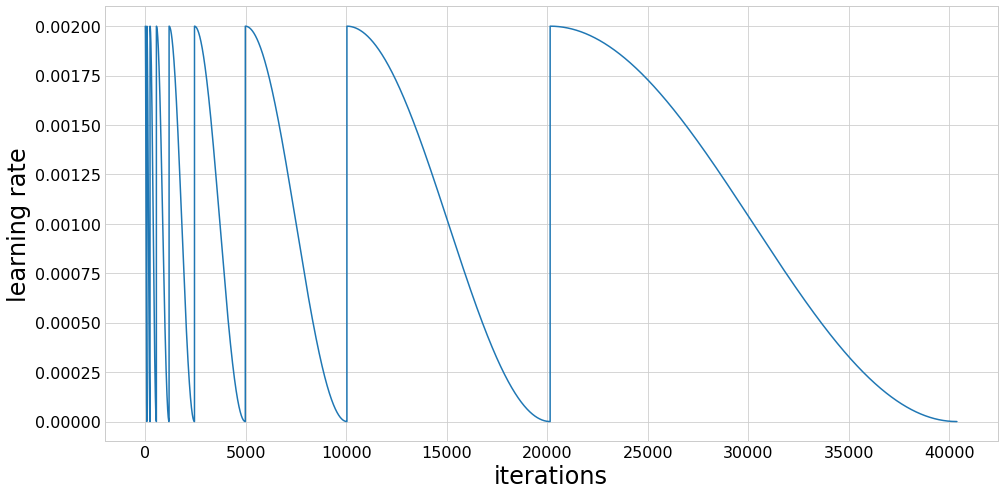

Fold took 495.610s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.368859). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184819). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8485692148969976e-05
2 New best found: 3.600052179972408e-05
3 New best found: 3.534769021644024e-05
5 New best found: 3.448849578417139e-05
6 New best found: 3.3702228119364005e-05
7 New best found: 3.366766199033009e-05
10 New best found: 3.3599465001316276e-05
12 New best found: 3.292812540603336e-05
13 New best found: 3.282976717018755e-05
14 New best found: 3.272455776750576e-05
15 New best found: 3.27080004819436e-05
21 New best found: 3.264352231344674e-05
22 New best found: 3.258635641977889e-05
24 New best found: 3.238961395254591e-05
26 New best found: 3.234286042716121e-05
27 New best found: 3.216043628490297e-05
28 New best found: 3.210605912609026e-05
30 New best found: 3.2043328776489945e-05
31 New best found: 3.2040439946285916e-05
50 New best found: 3.194023765827296e-05
51 New best found: 3.186434473172994e-05
53 New best found: 3.186181506753201e-05
54 New best found: 3.182316556631122e-05
57 New best found: 3.170903429854661e-05
59 New best found:

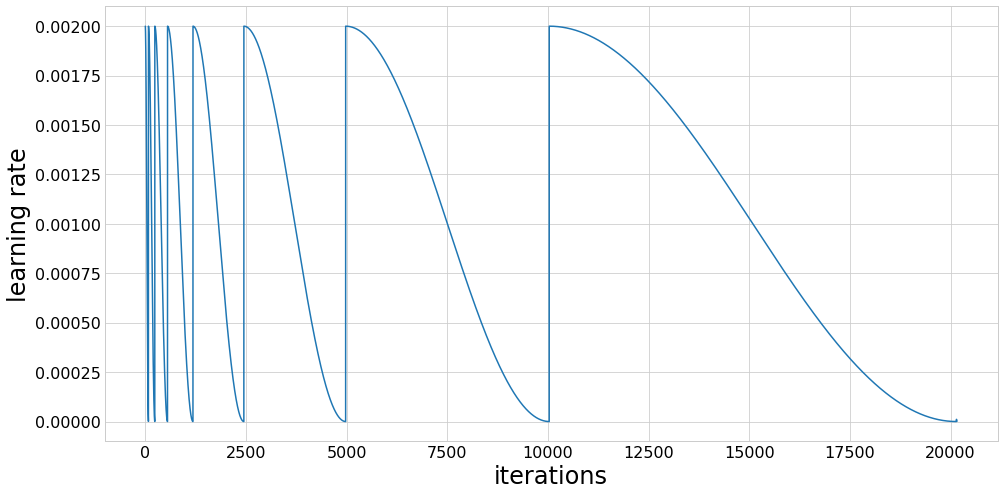

Fold took 259.490s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.432752). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216779). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9005069525477914e-05
2 New best found: 3.692246806199184e-05
3 New best found: 3.6117316838673475e-05
5 New best found: 3.517061015431048e-05
6 New best found: 3.464278471904513e-05
7 New best found: 3.446153710104925e-05
10 New best found: 3.435013119190722e-05
11 New best found: 3.396295295159161e-05
13 New best found: 3.3770768571263175e-05
14 New best found: 3.3693017618163416e-05
21 New best found: 3.3673732510598986e-05
22 New best found: 3.366007760217669e-05
23 New best found: 3.345475323386313e-05
24 New best found: 3.330366743864926e-05
27 New best found: 3.32281773701374e-05
28 New best found: 3.31370801280587e-05
29 New best found: 3.3117191674015196e-05
30 New best found: 3.308375568003888e-05
31 New best found: 3.3076050335600705e-05
56 New best found: 3.298333267074642e-05
57 New best found: 3.289934269750311e-05
58 New best found: 3.289187132418102e-05
109 New best found: 3.284532975803755e-05
111 New best found: 3.283279896123669e-05
120 New best fo

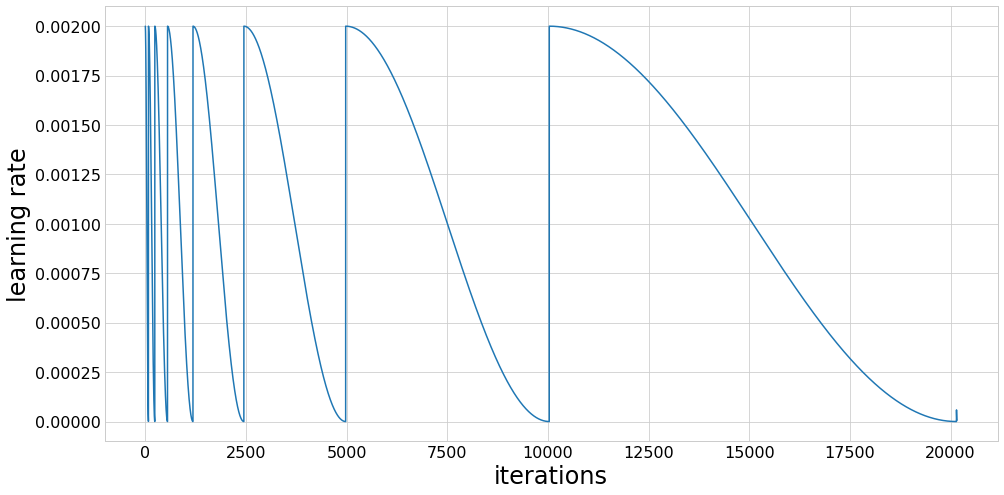

Fold took 262.532s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.435275). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218056). Check your callbacks.
  % delta_t_median)


1 New best found: 3.873580972867785e-05
2 New best found: 3.614111924543977e-05
3 New best found: 3.539837827847805e-05
4 New best found: 3.505046492209658e-05
5 New best found: 3.4511979011585934e-05
6 New best found: 3.43289405136602e-05
7 New best found: 3.3799752304912545e-05
11 New best found: 3.3401192857127174e-05
12 New best found: 3.32339043772663e-05
13 New best found: 3.288484808581415e-05
14 New best found: 3.279468131222529e-05
15 New best found: 3.2764877133013215e-05
25 New best found: 3.2521160201577e-05
26 New best found: 3.2349698380858174e-05
29 New best found: 3.226807577011641e-05
30 New best found: 3.223323921556585e-05
31 New best found: 3.2228739791025874e-05
47 New best found: 3.218141108227428e-05
49 New best found: 3.2003047966281885e-05
50 New best found: 3.192060994770145e-05
54 New best found: 3.184323199093342e-05
58 New best found: 3.176505383307813e-05
59 New best found: 3.173834229382919e-05
60 New best found: 3.170839334197808e-05
61 New best found: 3

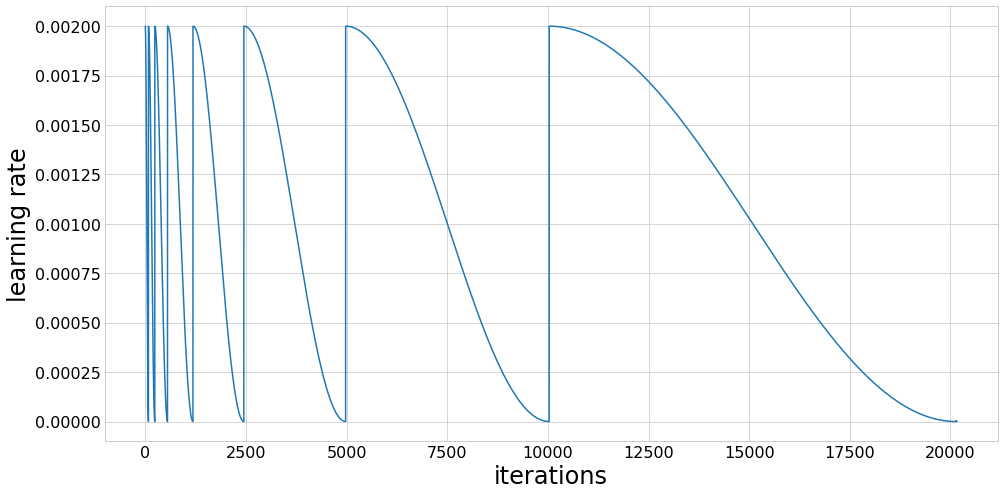

Fold took 270.645s


______________________________________
Training finished
Cross-validation took 2972.211s 


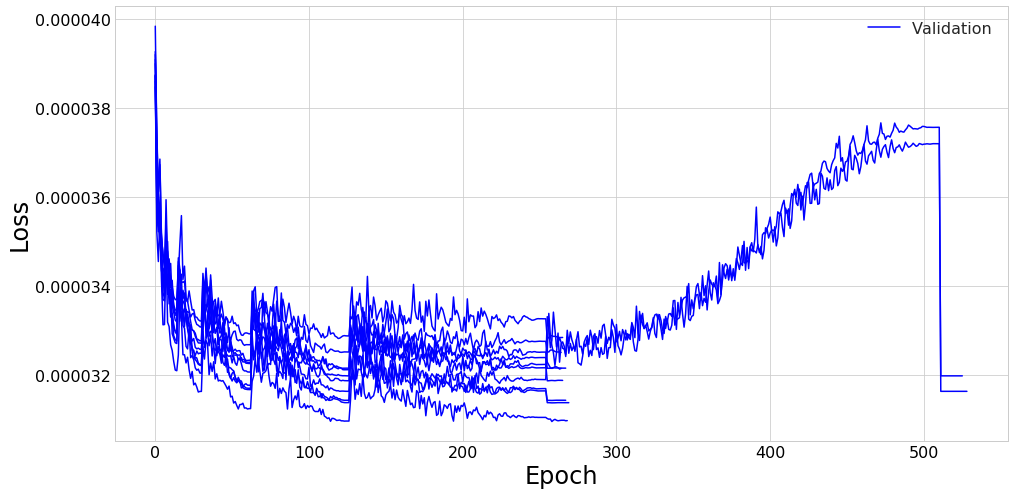

Mean loss = 3.19e-05 +- 2e-07
Mean wAUC = 0.0638 +- 0.0006
Mean AUC = 0.0994 +- 0.0005
Mean AMS = 3.95 +- 0.1
Mean cut = 0.962 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 0 with loss = 3.0952324345001945e-05
Model 1 is 9 with loss = 3.137219800555613e-05
Model 2 is 7 with loss = 3.1426780586480165e-05
Model 3 is 2 with loss = 3.163200518636187e-05
Model 4 is 5 with loss = 3.1869385962434724e-05
Model 5 is 6 with loss = 3.198011968779611e-05
Model 6 is 1 with loss = 3.21075339740699e-05
Model 7 is 3 with loss = 3.214966114173876e-05
Model 8 is 4 with loss = 3.2499513693128516e-05
Model 9 is 8 with loss = 3.2819725570965864e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017652671182528138s per sample

Predicting fold 2 out of 10
Prediction took 0.00033770994134247305s per sample

Predicting fold 3 out of 10
Prediction took 0.0003299201358109713s per sample

Predicting fold 4 out of 10
Prediction took 0.0003336794231086969s per sample

Predicting fold 5 out of 10
Prediction took 0.00033375764600932596s per sample

Predicting fold 6 out of 10
Prediction took 0.0003351656224578619s per sample

Predicting fold 7 out of 10
Prediction took 0.0003337605074048042s per sample

Predicting fold 8 out of 10
Prediction took 0.0003368076231330633s per sample

Predicting fold 9 out of 10
Prediction took 0.00033332024794071913s per sample

Predicting fold 10 out of 10
Prediction took 0.0003302177954465151s per sample



In [15]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9027728088148798, weighted 0.9355616788018045


Best cut at 0.9684573621959897 corresponds to AMS of 3.8283372787928647
Maximum AMS for data is 3.9061236694926142 at cut of 0.964882493019104
CPU times: user 25.2 s, sys: 0 ns, total: 25.2 s
Wall time: 25.2 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


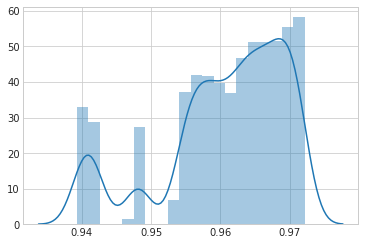

In [17]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9606571 corresponds to AMS of 3.803622004906909
Maximum AMS for data is 3.9061236694926142 at cut of 0.964882493019104
CPU times: user 105 ms, sys: 74.9 ms, total: 180 ms
Wall time: 83.1 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


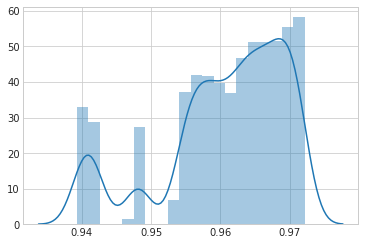

In [18]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [19]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [20]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0055950297553092245s per sample

Predicting fold 2 out of 10
Prediction took 0.005606351345032454s per sample

Predicting fold 3 out of 10
Prediction took 0.005587369555234909s per sample

Predicting fold 4 out of 10
Prediction took 0.005592133616097271s per sample

Predicting fold 5 out of 10
Prediction took 0.0055686921807006s per sample

Predicting fold 6 out of 10
Prediction took 0.005594301201403141s per sample

Predicting fold 7 out of 10
Prediction took 0.005622843969799578s per sample

Predicting fold 8 out of 10
Prediction took 0.005577528356015682s per sample

Predicting fold 9 out of 10
Prediction took 0.005453313222900033s per sample

Predicting fold 10 out of 10
Prediction took 0.005434007314220071s per sample



In [21]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [22]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9028837059007617, weighted 0.9356193646784052


Best cut at 0.9678788708972262 corresponds to AMS of 3.83269310467092
Maximum AMS for data is 3.9205591531801307 at cut of 0.9591256976127625
CPU times: user 24.9 s, sys: 0 ns, total: 24.9 s
Wall time: 24.9 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


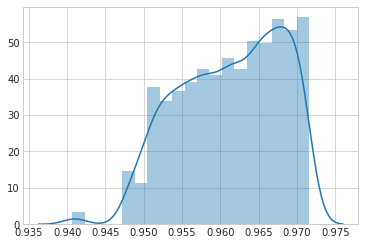

In [23]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.96126884 corresponds to AMS of 3.826562455462516
Maximum AMS for data is 3.9205591531801307 at cut of 0.9591256976127625
CPU times: user 93 ms, sys: 77.8 ms, total: 171 ms
Wall time: 85.4 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


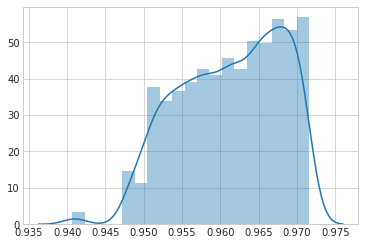

In [24]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [25]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.000324502772804011s per sample

Predicting fold 2 out of 10
Prediction took 0.0003234897222539241s per sample

Predicting fold 3 out of 10
Prediction took 0.0003218788255514069s per sample

Predicting fold 4 out of 10
Prediction took 0.00032318493451245805s per sample

Predicting fold 5 out of 10
Prediction took 0.0003253567640584978s per sample

Predicting fold 6 out of 10
Prediction took 0.00032412355642088436s per sample

Predicting fold 7 out of 10
Prediction took 0.0003285182900896127s per sample

Predicting fold 8 out of 10
Prediction took 0.0003269185485487634s per sample

Predicting fold 9 out of 10
Prediction took 0.00032619752765379167s per sample

Predicting fold 10 out of 10
Prediction took 0.00032524264663119206s per sample

CPU times: user 3min 13s, sys: 12 s, total: 3min 25s
Wall time: 2min 58s


In [27]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.571727367264279 : 3.6420038669561228


(3.571727367264279, 3.6420038669561228)

In [28]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.6568967151895007 : 3.7494772177191065


(3.6568967151895007, 3.7494772177191065)

# Test scoring - With TTA

In [29]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [30]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005279857645691796s per sample

Predicting fold 2 out of 10
Prediction took 0.005284229617819867s per sample

Predicting fold 3 out of 10
Prediction took 0.0052621328990906475s per sample

Predicting fold 4 out of 10
Prediction took 0.005280439465476031s per sample

Predicting fold 5 out of 10
Prediction took 0.005284448786164549s per sample

Predicting fold 6 out of 10
Prediction took 0.005287751311182298s per sample

Predicting fold 7 out of 10
Prediction took 0.005278902648457072s per sample

Predicting fold 8 out of 10
Prediction took 0.005285556690005416s per sample

Predicting fold 9 out of 10
Prediction took 0.005295123401639814s per sample

Predicting fold 10 out of 10
Prediction took 0.005284969405931505s per sample

CPU times: user 52min 13s, sys: 3min 12s, total: 55min 26s
Wall time: 48min 25s


In [31]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.6053717823968436 : 3.6522645547209462


(3.6053717823968436, 3.6522645547209462)

In [32]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.626696888670411 : 3.756351257434535


(3.626696888670411, 3.756351257434535)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)